
# ASR & Multimodal Foundation Models — **ETAL 2025 Colab Version** 🇬

**How to run:**  
1. Open [Colab](https://colab.research.google.com).  
2. Click **Upload** and select this notebook.  
3. (Menu) **Runtime → Change runtime type → GPU** (recommended).  
4. Run the cells from top to bottom.

**Contents**

1) Whisper multilingual ASR
2) Spectrograms (representations)  
3) Wav2Vec2 ASR (SSL)  
4) Naver Labs Europe's mHuBERT - ASR in French & transcription in discrete acoustic units   


## 0) Setup — Dependencies (Colab)

In [2]:

# Check GPU (optional)
!nvidia-smi -L || true

# Upgrade pip, install deps commonly available on Colab
!pip -q install --upgrade pip
!pip -q install librosa soundfile transformers accelerate datasets numpy scipy matplotlib umap-learn
# Install Whisper (reference implementation) + faster-whisper optional
!pip -q install git+https://github.com/openai/whisper.git
!pip -q install faster-whisper
# Install torchaudio (compatible with Colab's torch)
!pip -q install torchaudio

GPU 0: Tesla T4 (UUID: GPU-882cce62-ee15-6dd5-abbf-a55b23c7ab10)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Audio Input: Upload or Record Audio in Colab

In [3]:

import IPython.display as ipd
from google.colab import files, output
from base64 import b64decode
from pathlib import Path
import uuid

def upload_audio(accept='.wav,.mp3,.m4a'):
    print("Upload an audio file:", accept)
    up = files.upload()
    fname = list(up.keys())[0]
    print("Uploaded:", fname)
    return fname

def play_audio(path, rate=None):
    if path.lower().endswith(".wav") and rate is not None:
        return ipd.Audio(path, rate=rate)
    return ipd.Audio(path)

def record_audio(seconds=5, sample_rate=16000):
    # JS-based recorder; returns saved wav filename
    rec_id = "rec_" + str(uuid.uuid4()).replace("-", "") + ".wav"
    display(ipd.HTML(f'''
    <script>
    async function record(sec) {{
      const stream = await navigator.mediaDevices.getUserMedia({{audio:true}});
      const mediaRecorder = new MediaRecorder(stream);
      const chunks = [];
      mediaRecorder.ondataavailable = e => chunks.push(e.data);
      mediaRecorder.start();
      await new Promise(r => setTimeout(r, sec*1000));
      mediaRecorder.stop();
      await new Promise(r => mediaRecorder.onstop = r);
      const blob = new Blob(chunks, {{ type: 'audio/webm' }});
      const arrayBuffer = await new Response(blob).arrayBuffer();
      const base64 = btoa(String.fromCharCode(...new Uint8Array(arrayBuffer)));
      google.colab.kernel.invokeFunction('notebook.saveAudio', [base64, '{rec_id}'], {{}});
    }}
    record({seconds});
    </script>
    Recording for {seconds} seconds...
    '''))

    def _save_audio(b64, fname):
        # Save webm → wav via pydub or ffmpeg would be ideal; fallback to write webm
        import pathlib
        p = pathlib.Path(fname).with_suffix(".webm")
        with open(p, "wb") as f:
            f.write(b64decode(b64))
        print("Saved", p, "(webm). If needed, convert to wav with ffmpeg: !ffmpeg -i input.webm output.wav")
        return str(p)

    output.register_callback('notebook.saveAudio', _save_audio)
    return rec_id  # real path printed by callback

print("Helpers ready. Use upload_audio() or record_audio(seconds=5).")


#record_audio(seconds=5)


Helpers ready. Use upload_audio() or record_audio(seconds=5).


## 1) Whisper — Multilingual ASR

In [4]:

import whisper, torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model_size = "small"   # small / medium / large
model = whisper.load_model(model_size, device=device)

def transcribe_with_whisper(fname, language=None, task="transcribe"):
    print(f"Decoding on: {device} | model: {model_size}")
    options = dict(task=task)
    if language is not None:
        options["language"] = language
    result = model.transcribe(fname, **options)
    print("\n--- TRANSCRIPT ---\n", result["text"])
    return result

#LB: you can either import audio or record audio here, use upload_audio() or record_audio()
fname = upload_audio()
#english file
#transcribe_with_whisper(fname, language='en')
transcribe_with_whisper(fname)




100%|███████████████████████████████████████| 461M/461M [01:01<00:00, 7.91MiB/s]


Upload an audio file: .wav,.mp3,.m4a


Saving common_voice_en_21731401.wav to common_voice_en_21731401.wav
Uploaded: common_voice_en_21731401.wav
Decoding on: cuda | model: small

--- TRANSCRIPT ---
  He is sometimes referred to as the Marko Polo of Japan.


{'text': ' He is sometimes referred to as the Marko Polo of Japan.',
 'segments': [{'id': 0,
   'seek': 0,
   'start': 0.0,
   'end': 8.0,
   'text': ' He is sometimes referred to as the Marko Polo of Japan.',
   'tokens': [50364,
    634,
    307,
    2171,
    10839,
    281,
    382,
    264,
    3934,
    78,
    3635,
    78,
    295,
    3367,
    13,
    50764],
   'temperature': 0.0,
   'avg_logprob': -0.4269377203548656,
   'compression_ratio': 0.9016393442622951,
   'no_speech_prob': 0.1241736188530922}],
 'language': 'en'}

## 2) Spectrograms  — Visualize representations
> Add blockquote



Upload an audio file: .wav,.mp3,.m4a


Saving common_voice_en_21731401.wav to common_voice_en_21731401 (1).wav
Uploaded: common_voice_en_21731401 (1).wav


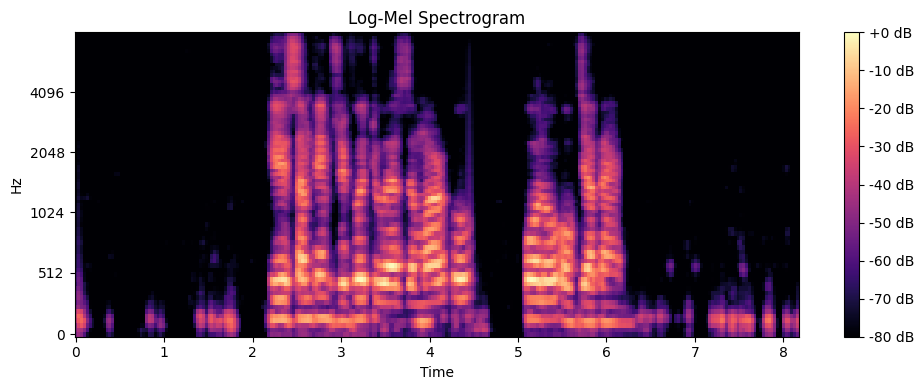

In [5]:

import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

def load_wav_mono(path, sr=16000):
    y, _sr = librosa.load(path, sr=sr, mono=True)
    return y, sr

def show_spectrogram(y, sr, title="Log-Mel Spectrogram"):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def add_noise(y, snr_db=10):
    rms = np.sqrt(np.mean(y**2))
    noise_rms = rms / (10**(snr_db/20))
    noise = np.random.normal(0, noise_rms, y.shape)
    return y + noise

#LB: you can either import audio or record audio here, use upload_audio() or record_audio()
fname = upload_audio()
y,sr = load_wav_mono(fname)
show_spectrogram(y,sr)
#y2=add_noise(y,5)
#show_spectrogram(y2,sr)


## 3) Wav2Vec2 — Self-Supervised ASR (Hugging Face Pipeline) - English ASR only !

In [6]:

from transformers import pipeline
asr = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")
#LB: you can either import audio or record audio here, use upload_audio() or record_audio()
#upload or record english wav file only
fname = upload_audio()
asr(fname)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Device set to use cuda:0


Upload an audio file: .wav,.mp3,.m4a


Saving common_voice_en_21731401.wav to common_voice_en_21731401 (2).wav
Uploaded: common_voice_en_21731401 (2).wav


{'text': 'HE IS SOMETIMES REFERRED TO AS THE MARCL POLO OF JARBAN'}

## 4) mHuBERT (utter-project/mHuBERT-147) — ASR in French + transcription in discrete acoustic units

Upload an audio file: .wav,.mp3,.m4a


Saving common_voice_fr_20024763.wav to common_voice_fr_20024763.wav
Uploaded: common_voice_fr_20024763.wav

--- mhubert asr (fr) ---
 [CTC]d[CTC]a[CTC]ns[CTC] c[CTC]e[CTC]s[CTC] p[CTC]a[CTC]s[CTC]t[CTC]o[CTC]r[CTC]a[CTC]d[CTC]es[CTC] [CTC]i[CTC]l[CTC] che[CTC]r[CTC]ch[CTC]ai[CTC]t[CTC] à[CTC] d[CTC]on[CTC]n[CTC]er[CTC] [CTC]à[CTC] c[CTC]e[CTC] g[CTC]e[CTC]n[CTC]re[CTC] a[CTC]n[CTC]c[CTC]i[CTC]e[CTC]n[CTC] un[CTC]e[CTC] f[CTC]o[CTC]r[CTC]m[CTC]e[CTC] mo[CTC]d[CTC]e[CTC]r[CTC]n[CTC]e[CTC]

--- mhubert asr (fr) — nettoyé ---
 dans ces pastorades il cherchait à donner à ce genre ancien une forme moderne

--- discrete units (k=50) ---
first 200 unit ids: 32 27 44 20 20 44 44 31 6 1 31 1 31 31 1 1 31 31 8 31 0 16 0 16 16 16 8 31 8 8 16 6 6 8 16 30 30 30 30 30 30 30 30 30 37 47 47 28 28 28 28 28 28 49 49 35 35 35 35 35 35 3 30 30 12 47 15 28 28 28 28 34 40 30 30 30 43 9 9 9 9 9 9 13 13 13 13 25 25 34 34 34 34 34 34 34 45 45 45 0 45 45 45 45 21 49 49 49 15 15 15 15 24 24 24 24 24 4 38 12 12 15

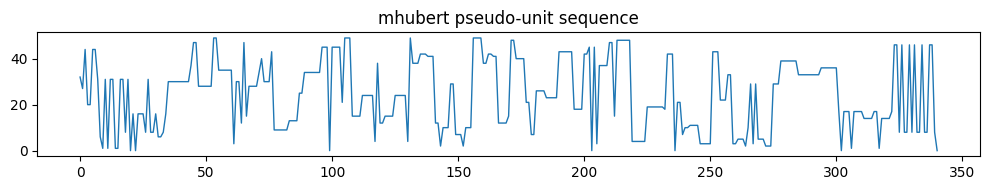

In [10]:
# === mHuBERT — French ASR + discrete units (patched tokenizer load) ===
!pip -q install -U "transformers>=4.43" sentencepiece
try:
    import torchaudio  # keep existing torch to avoid resolver conflicts
except Exception:
    !pip -q install torchaudio

import torch, torchaudio, numpy as np, matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from transformers import (
    Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor,
    AutoFeatureExtractor, AutoModel, HubertConfig, HubertPreTrainedModel, HubertModel
)
import torch.nn as nn
from transformers.modeling_outputs import CausalLMOutput

# ----- minimal CTC head (French ASR) -----
class VanillaNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.act_fn = nn.ReLU()
    def forward(self, hidden_states: torch.FloatTensor):
        return self.act_fn(self.linear(hidden_states))

class mHubertForCTC(HubertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.hubert = HubertModel(config)
        self.dropout = nn.Dropout(getattr(config, "final_dropout", 0.0))
        self.has_interface = getattr(config, "add_interface", False)
        hs = config.hidden_size
        if self.has_interface:
            n_layers = getattr(config, "num_interface_layers", 0)
            self.interface = nn.ModuleList([VanillaNN(hs, hs) for _ in range(n_layers)])
        self.lm_head = nn.Linear(hs, config.vocab_size)
        self.post_init()
    def forward(self, input_values, attention_mask=None, output_attentions=None,
                output_hidden_states=None, return_dict=None, labels=None):
        outputs = self.hubert(
            input_values, attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=True, return_dict=True
        )
        hidden_states = self.dropout(outputs.last_hidden_state)
        if self.has_interface:
            for layer in self.interface:
                hidden_states = layer(hidden_states)
        logits = self.lm_head(hidden_states)
        return CausalLMOutput(logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

def load_mhubert_fr_asr():
    # ✅ tokenizer: load from repo (or download vocab.json if needed)
    try:
        tok = Wav2Vec2CTCTokenizer.from_pretrained(
            "naver/mHuBERT-147-ASR-fr",
            unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|"
        )
    except Exception:
        vocab_path = hf_hub_download("naver/mHuBERT-147-ASR-fr", "vocab.json")
        tok = Wav2Vec2CTCTokenizer(
            vocab_path, unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|"
        )
    fe  = Wav2Vec2FeatureExtractor.from_pretrained("utter-project/mHuBERT-147")
    proc = Wav2Vec2Processor(feature_extractor=fe, tokenizer=tok)
    cfg = HubertConfig.from_pretrained("naver/mHuBERT-147-ASR-fr")
    model = mHubertForCTC.from_pretrained("naver/mHuBERT-147-ASR-fr", config=cfg)
    model.eval()
    return model, proc

# ----- discrete units (same as before; lightweight numpy k-means) -----
def kmeans_np(X, k=50, iters=20, seed=0):
    rng = np.random.default_rng(seed)
    T, D = X.shape
    centroids = X[rng.choice(T, size=k, replace=False)].copy()
    labels = np.zeros(T, dtype=np.int32)
    for _ in range(iters):
        x2 = (X * X).sum(axis=1, keepdims=True)
        c2 = (centroids * centroids).sum(axis=1)[None, :]
        distances = x2 + c2 - 2.0 * (X @ centroids.T)
        new_labels = distances.argmin(axis=1)
        if np.array_equal(new_labels, labels): break
        labels = new_labels
        for j in range(k):
            mask = labels == j
            centroids[j] = X[mask].mean(axis=0) if mask.any() else X[rng.integers(0, T)]
    return labels

def mhubert_frame_embeddings(fname, hubert_id="utter-project/mHuBERT-147", layer=-1):
    base_fe = AutoFeatureExtractor.from_pretrained(hubert_id)
    base = AutoModel.from_pretrained(hubert_id)
    wav, sr = torchaudio.load(fname)
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000); sr = 16000
    inputs = base_fe(wav.squeeze().numpy(), sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        out = base(**inputs, output_hidden_states=True)
    hs = out.hidden_states[layer] if layer is not None else out.last_hidden_state
    return hs[0].cpu().numpy().astype(np.float32)

# ----- pipeline: upload → ASR (FR) → units -----
#LB: you can either import audio or record audio here, use upload_audio() or record_audio()
fname = upload_audio()

# 1) mHuBERT ASR (French only)
try:
    asr_model, asr_proc = load_mhubert_fr_asr()
    wav, sr = torchaudio.load(fname)
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000); sr = 16000
    inputs = asr_proc(wav.squeeze().numpy(), sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        logits = asr_model(inputs.input_values).logits
        pred_ids = torch.argmax(logits, dim=-1)
        # --- décodage brut (garde les tokens spéciaux) ---
        decoded_raw = asr_proc.tokenizer.batch_decode(pred_ids, skip_special_tokens=False)
        fr_text_raw = decoded_raw[0]
        # --- version nettoyée lisible ---
        import re
        fr_text_clean = fr_text_raw.replace("[CTC]", "").replace("|", " ")
        fr_text_clean = re.sub(r"\s+", " ", fr_text_clean).strip()
        # petites élisions FR courantes: j / n / l / d / c / qu / jusqu / lorsqu / puisqu
        fr_text_clean = re.sub(r"\b([JjNnLlDdCc])\s+([aeiouhàâäéèêëïîôöùûüAEIOUH])", r"\1'\2", fr_text_clean)
        fr_text_clean = re.sub(r"\b([Qq]u|[Jj]usqu|[Ll]orsqu|[Pp]uisqu)\s+([aeiouhàâäéèêëïîôöùûüAEIOUH])", r"\1'\2", fr_text_clean)

        print("\n--- mhubert asr (fr) ---\n", fr_text_raw)          # ex: [CTC]j[CTC]e...
        print("\n--- mhubert asr (fr) — nettoyé ---\n", fr_text_clean)  # ex: je n'accepte pas ...

except Exception as e:
    print("mhubert asr load/inference skipped:", e)

# 2) discrete units for any language
emb = mhubert_frame_embeddings(fname, layer=-1)
units = kmeans_np(emb, k=50, iters=20, seed=0)
print("\n--- discrete units (k=50) ---")
print("first 200 unit ids:", " ".join(map(str, units[:200])))
print(f"(total frames: {len(units)}, inventory size: 50)")
try:
    plt.figure(figsize=(10, 2)); plt.plot(units, linewidth=1); plt.title("mhubert pseudo-unit sequence"); plt.tight_layout(); plt.show()
except Exception:
    pass





### 🔁 suggested post-class lab exercises: compare asr systems across english and french

students will **record or upload** a small dataset of **5–10 short audio clips** (1-3s each) in **french** or **english**, then run different asr models and compare their outputs.

---

#### 📁 step 1: prepare a small dataset
- use the `upload_audio()` helper or colab's built-in recorder.
- name files clearly: `fr_01.wav`, `fr_02.wav`, `en_01.wav`, `en_02.wav`, etc.

---

#### 🇬🇧 step 2: english clips → whisper vs. wav2vec2
- run **whisper** on each english audio file.
- run **wav2vec2** on the same files.
- **analyze**:
  - differences in transcription accuracy, punctuation, and formatting
  - impact of multilingual vs. english-only training

---

#### 🇫🇷 step 3: french clips → whisper vs. mhubert-fr
- run **whisper** on each french audio file.
- run **mhubert-fr (ctc)** on the same files.
- compare the transcripts side-by-side.
- **analyze**:
  - differences in transcription accuracy, punctuation, and formatting

---

